In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Dataset and Dependencies

In [ ]:
!unzip '/content/drive/MyDrive/Final Project Indonesia AI/Apple Dataset/Apple.zip'

Archive:  /content/drive/MyDrive/Final Project Indonesia AI/Apple Dataset/Apple.zip
   creating: Apple/
  inflating: Apple/README.dataset.txt  
  inflating: Apple/README.roboflow.txt  
   creating: Apple/test/
  inflating: Apple/test/apple--1-_jpg.rf.f8d90247da966c6e7e3f3b915fde5c1a.jpg  
  inflating: Apple/test/apple--10-_jpg.rf.0b1b5993075f3cfb555045e455cecf3c.jpg  
  inflating: Apple/test/apple--106-_jpg.rf.e94c7574363c7c61fb5c051fa40047f0.jpg  
  inflating: Apple/test/apple--11-_jpg.rf.d9e27c763773cf020bfb8dc7813a4ded.jpg  
  inflating: Apple/test/apple--111-_jpg.rf.6c28cc6ba934f4ffd19b3f60381a94a3.jpg  
  inflating: Apple/test/apple--113-_jpg.rf.50149d4412f2f49b138139dc47d578a9.jpg  
  inflating: Apple/test/apple--116-_jpg.rf.e1447cfeeb56fe12de0faf3dc5ead3b7.jpg  
  inflating: Apple/test/apple--119-_jpg.rf.129e3871c50316b174a5b44d44d04fdc.jpg  
  inflating: Apple/test/apple--12-_jpg.rf.b95eee33cb534ab2fc9675dc4836c46b.jpg  
  inflating: Apple/test/apple--120-_jpg.rf.4afc7fbac8c40e

In [ ]:
!wget https://raw.githubusercontent.com/pytorch/vision/v0.15.2/references/detection/transforms.py
!wget https://raw.githubusercontent.com/pytorch/vision/v0.15.2/references/detection/engine.py
!wget https://raw.githubusercontent.com/pytorch/vision/v0.15.2/references/detection/utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/v0.15.2/references/detection/coco_eval.py
!wget https://raw.githubusercontent.com/pytorch/vision/v0.15.2/references/detection/coco_utils.py

--2023-09-02 12:18:42--  https://raw.githubusercontent.com/pytorch/vision/v0.15.2/references/detection/transforms.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23337 (23K) [text/plain]
Saving to: ‘transforms.py’

transforms.py       100%[===================>]  22.79K  --.-KB/s    in 0s      

2023-09-02 12:18:43 (91.2 MB/s) - ‘transforms.py’ saved [23337/23337]

--2023-09-02 12:18:43--  https://raw.githubusercontent.com/pytorch/vision/v0.15.2/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4032 

# Import Library

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from sklearn import preprocessing
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import xml.etree.ElementTree as ET

from torchvision.transforms import transforms
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from engine import train_one_epoch, evaluate
import utils

# Root Dataset

## Train Files

In [ ]:
Base_path = '/content/Apple'
img_train_path = os.path.join(Base_path, 'train')
xml_train_path = os.path.join(Base_path, img_train_path, 'labels')
xml_train_files = [os.path.join(xml_train_path, f) for f in os.listdir(xml_train_path)]

## Test Files

In [ ]:
img_test_path = os.path.join(Base_path, 'valid')
xml_test_path = os.path.join(Base_path, img_test_path, 'labels')
xml_test_files = [os.path.join(xml_test_path, f) for f in os.listdir(xml_test_path)]

# Valid Files

In [ ]:
img_valid_path = os.path.join(Base_path, 'test')
xml_valid_path = os.path.join(Base_path, img_valid_path, 'labels')
xml_valid_files = [os.path.join(xml_valid_path, f) for f in os.listdir(xml_valid_path)]

# Extract XML

In [ ]:
class XMLParser(object):
  def __init__(self, xml_files):
    self.xml_files = xml_files
    self.root = ET.parse(self.xml_files).getroot()
    self.objects = self.root.findall('object')
    self.img_path = os.path.join(img_train_path, self.root.find('filename').text)
    self.image_id = self.root.find('filename').text
    self.names = self.get_names()
    self.boxes = self.get_bndbox()

  def parse_xml(self):
    tree = ET.parse(self.xml_files)
    return tree.getroot()

  def get_names(self):
    names = []
    for obj in self.objects:
      name = obj.find('name')
      names.append(name.text)

    return np.array(names)

  def get_bndbox(self):
    boxes = []
    for obj in self.objects:
      coordinates = []
      bndbox = obj.find('bndbox')
      coordinates.append(np.int32(bndbox.find('xmin').text))
      coordinates.append(np.int32(bndbox.find('ymin').text))
      coordinates.append(np.int32(bndbox.find('xmax').text))
      coordinates.append(np.int32(bndbox.find('ymax').text))
      boxes.append(coordinates)

    return np.array(boxes)

In [ ]:
def xml_files_to_df(xml_files):
  names = []
  boxes = []
  image_id = []
  xml_path = []
  img_path = []

  for file in xml_files:
    xml = XMLParser(file)
    names.extend(xml.names)
    boxes.extend(xml.boxes)
    image_id.extend([xml.image_id] * len(xml.names))
    xml_path.extend([xml.xml_files] * len(xml.names))
    img_path.extend([xml.img_path] * len(xml.names))

  a = {'image_id' : image_id,
       'names' : names,
       'boxes' : boxes,
       'xml_path' : xml_path,
       'img_path' : img_path}

  df = pd.DataFrame.from_dict(a, orient = 'index')
  df = df.transpose()

  return df

## Dictionary

In [ ]:
classes_dict = {1 : 'apple', 2 : 'damaged_apple'}

## Train

In [ ]:
df_train = xml_files_to_df(xml_train_files)
df_train.head()

,image_id,names,boxes,xml_path,img_path
0,apple--363-_jpg.rf.7f80d0984be1e9a1eafb53ab123...,apple,"[21, 88, 154, 207]",/content/Apple/train/labels/apple--363-_jpg.rf...,/content/Apple/train/apple--363-_jpg.rf.7f80d0...
1,apple--363-_jpg.rf.7f80d0984be1e9a1eafb53ab123...,apple,"[157, 139, 303, 281]",/content/Apple/train/labels/apple--363-_jpg.rf...,/content/Apple/train/apple--363-_jpg.rf.7f80d0...
2,apple--363-_jpg.rf.7f80d0984be1e9a1eafb53ab123...,apple,"[170, 75, 286, 144]",/content/Apple/train/labels/apple--363-_jpg.rf...,/content/Apple/train/apple--363-_jpg.rf.7f80d0...
3,damaged_apple--201-_jpg.rf.ac3428dbe5cb52e65e4...,damaged_apple,"[200, 113, 344, 247]",/content/Apple/train/labels/damaged_apple--201...,/content/Apple/train/damaged_apple--201-_jpg.r...
4,damaged_apple--21-_jpg.rf.bd94a1b294a0b8a10673...,damaged_apple,"[33, 96, 409, 320]",/content/Apple/train/labels/damaged_apple--21-...,/content/Apple/train/damaged_apple--21-_jpg.rf...


In [ ]:
# Unique value in train
df_train['names'].value_counts()

apple            1483
damaged_apple     497
Name: names, dtype: int64

In [ ]:
# remove extension from image_id
df_train['img_id'] = df_train['image_id'].apply(lambda x: x.replace('.jpg', ''))
df_train.drop(columns = ['image_id'], inplace = True)
df_train.head()

,names,boxes,xml_path,img_path,img_id
0,apple,"[21, 88, 154, 207]",/content/Apple/train/labels/apple--363-_jpg.rf...,/content/Apple/train/apple--363-_jpg.rf.7f80d0...,apple--363-_jpg.rf.7f80d0984be1e9a1eafb53ab123...
1,apple,"[157, 139, 303, 281]",/content/Apple/train/labels/apple--363-_jpg.rf...,/content/Apple/train/apple--363-_jpg.rf.7f80d0...,apple--363-_jpg.rf.7f80d0984be1e9a1eafb53ab123...
2,apple,"[170, 75, 286, 144]",/content/Apple/train/labels/apple--363-_jpg.rf...,/content/Apple/train/apple--363-_jpg.rf.7f80d0...,apple--363-_jpg.rf.7f80d0984be1e9a1eafb53ab123...
3,damaged_apple,"[200, 113, 344, 247]",/content/Apple/train/labels/damaged_apple--201...,/content/Apple/train/damaged_apple--201-_jpg.r...,damaged_apple--201-_jpg.rf.ac3428dbe5cb52e65e4...
4,damaged_apple,"[33, 96, 409, 320]",/content/Apple/train/labels/damaged_apple--21-...,/content/Apple/train/damaged_apple--21-_jpg.rf...,damaged_apple--21-_jpg.rf.bd94a1b294a0b8a10673...


In [ ]:
enc = preprocessing.LabelEncoder()
df_train['labels'] = enc.fit_transform(df_train['names'])
df_train['labels'] = np.stack(df_train['labels'][i]+1 for i in range(len(df_train['labels'])))

In [ ]:
classes = df_train[['names', 'labels']].value_counts()
classes

names          labels
apple          1         1483
damaged_apple  2          497
dtype: int64

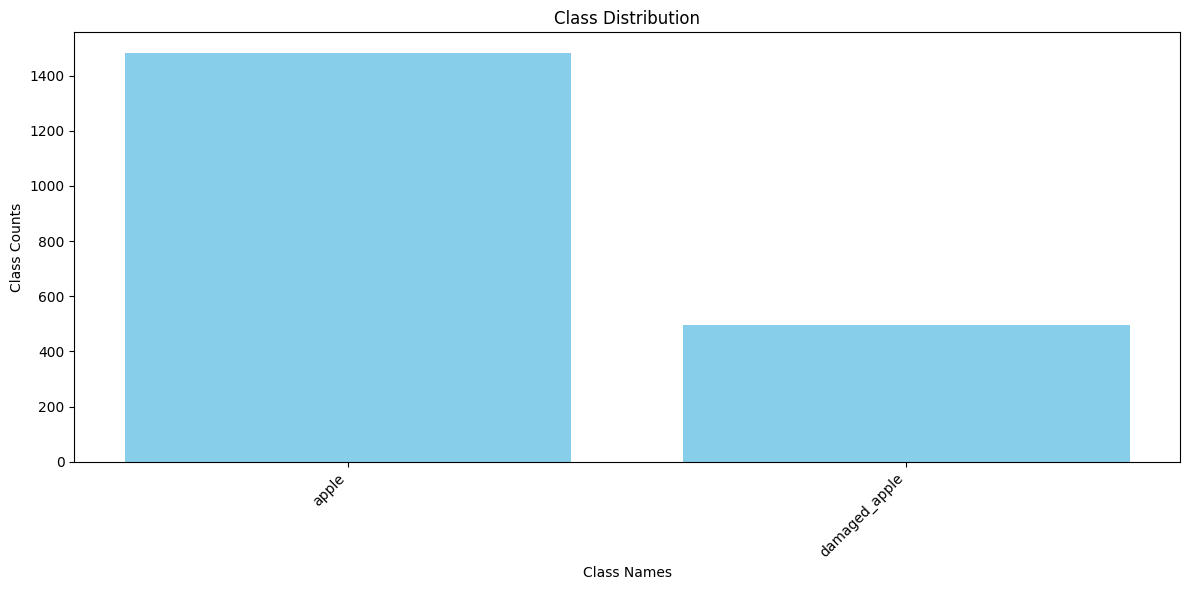

In [ ]:
class_names = classes.index.get_level_values('names')

# Nilai frekuensi kelas
class_counts = classes.values

# Buat plot
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel('Class Names')
plt.ylabel('Class Counts')
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')

# Tampilkan plot
plt.tight_layout()
plt.show()

In [ ]:
# bounding box coordinates point harus berada di kolom terpisah
df_train['xmin'] = -1
df_train['ymin'] = -1
df_train['xmax'] = -1
df_train['ymax'] = -1

df_train[['xmin', 'ymin', 'xmax', 'ymax']] = np.stack(df_train['boxes'][i] for i in range(len(df_train['boxes'])))

df_train.drop(columns = ['boxes'], inplace = True)
df_train['xmin'] = df_train['xmin'].astype(np.float)
df_train['ymin'] = df_train['ymin'].astype(np.float)
df_train['xmax'] = df_train['xmax'].astype(np.float)
df_train['ymax'] = df_train['ymax'].astype(np.float)

In [ ]:
df_train.drop(columns = ['names'], inplace = True)
df_train.head()

,xml_path,img_path,img_id,labels,xmin,ymin,xmax,ymax
0,/content/Apple/train/labels/damaged_apple--281...,/content/Apple/train/damaged_apple--281-_jpg.r...,damaged_apple--281-_jpg.rf.3187dcc1b9fc9837b54...,2,78.0,76.0,367.0,349.0
1,/content/Apple/train/labels/apple--238-_jpg.rf...,/content/Apple/train/apple--238-_jpg.rf.12d678...,apple--238-_jpg.rf.12d6781e8149121336be40628e0...,1,58.0,143.0,176.0,251.0
2,/content/Apple/train/labels/apple--238-_jpg.rf...,/content/Apple/train/apple--238-_jpg.rf.12d678...,apple--238-_jpg.rf.12d6781e8149121336be40628e0...,1,155.0,194.0,278.0,312.0
3,/content/Apple/train/labels/apple--238-_jpg.rf...,/content/Apple/train/apple--238-_jpg.rf.12d678...,apple--238-_jpg.rf.12d6781e8149121336be40628e0...,1,231.0,135.0,349.0,258.0
4,/content/Apple/train/labels/apple--238-_jpg.rf...,/content/Apple/train/apple--238-_jpg.rf.12d678...,apple--238-_jpg.rf.12d6781e8149121336be40628e0...,1,141.0,101.0,262.0,185.0


In [ ]:
df_train.shape

(1980, 8)

## Test

In [ ]:
df_test = xml_files_to_df(xml_test_files)
df_test.head()

,image_id,names,boxes,xml_path,img_path
0,damaged_apple--295-_jpg.rf.8172d0e132487a2e3f5...,damaged_apple,"[77, 98, 348, 326]",/content/Apple/valid/labels/damaged_apple--295...,/content/Apple/train/damaged_apple--295-_jpg.r...
1,apple--332-_jpg.rf.cb572319a5a842b99028fa2e5c4...,apple,"[6, 226, 101, 336]",/content/Apple/valid/labels/apple--332-_jpg.rf...,/content/Apple/train/apple--332-_jpg.rf.cb5723...
2,apple--332-_jpg.rf.cb572319a5a842b99028fa2e5c4...,apple,"[10, 110, 112, 211]",/content/Apple/valid/labels/apple--332-_jpg.rf...,/content/Apple/train/apple--332-_jpg.rf.cb5723...
3,apple--332-_jpg.rf.cb572319a5a842b99028fa2e5c4...,apple,"[43, 72, 151, 117]",/content/Apple/valid/labels/apple--332-_jpg.rf...,/content/Apple/train/apple--332-_jpg.rf.cb5723...
4,apple--332-_jpg.rf.cb572319a5a842b99028fa2e5c4...,damaged_apple,"[144, 70, 261, 177]",/content/Apple/valid/labels/apple--332-_jpg.rf...,/content/Apple/train/apple--332-_jpg.rf.cb5723...


In [ ]:
df_valid = xml_files_to_df(xml_valid_files)
df_valid['names'].value_counts()

apple            147
damaged_apple     10
Name: names, dtype: int64

In [ ]:
df_test['names'].value_counts()

apple            522
damaged_apple    201
Name: names, dtype: int64

In [ ]:
# remove extension from image_id
df_test['img_id'] = df_test['image_id'].apply(lambda x: x.replace('.jpg', ''))
df_test.drop(columns = ['image_id'], inplace = True)
df_test.head()

,names,boxes,xml_path,img_path,img_id
0,damaged_apple,"[77, 98, 348, 326]",/content/Apple/valid/labels/damaged_apple--295...,/content/Apple/train/damaged_apple--295-_jpg.r...,damaged_apple--295-_jpg.rf.8172d0e132487a2e3f5...
1,apple,"[6, 226, 101, 336]",/content/Apple/valid/labels/apple--332-_jpg.rf...,/content/Apple/train/apple--332-_jpg.rf.cb5723...,apple--332-_jpg.rf.cb572319a5a842b99028fa2e5c4...
2,apple,"[10, 110, 112, 211]",/content/Apple/valid/labels/apple--332-_jpg.rf...,/content/Apple/train/apple--332-_jpg.rf.cb5723...,apple--332-_jpg.rf.cb572319a5a842b99028fa2e5c4...
3,apple,"[43, 72, 151, 117]",/content/Apple/valid/labels/apple--332-_jpg.rf...,/content/Apple/train/apple--332-_jpg.rf.cb5723...,apple--332-_jpg.rf.cb572319a5a842b99028fa2e5c4...
4,damaged_apple,"[144, 70, 261, 177]",/content/Apple/valid/labels/apple--332-_jpg.rf...,/content/Apple/train/apple--332-_jpg.rf.cb5723...,apple--332-_jpg.rf.cb572319a5a842b99028fa2e5c4...


In [ ]:
enc = preprocessing.LabelEncoder()
df_test['labels'] = enc.fit_transform(df_test['names'])
df_test['labels'] = np.stack(df_test['labels'][i]+1 for i in range(len(df_test['labels'])))

In [ ]:
classes_test = df_test[['names', 'labels']].value_counts()
classes_test

names          labels
apple          1         522
damaged_apple  2         201
dtype: int64

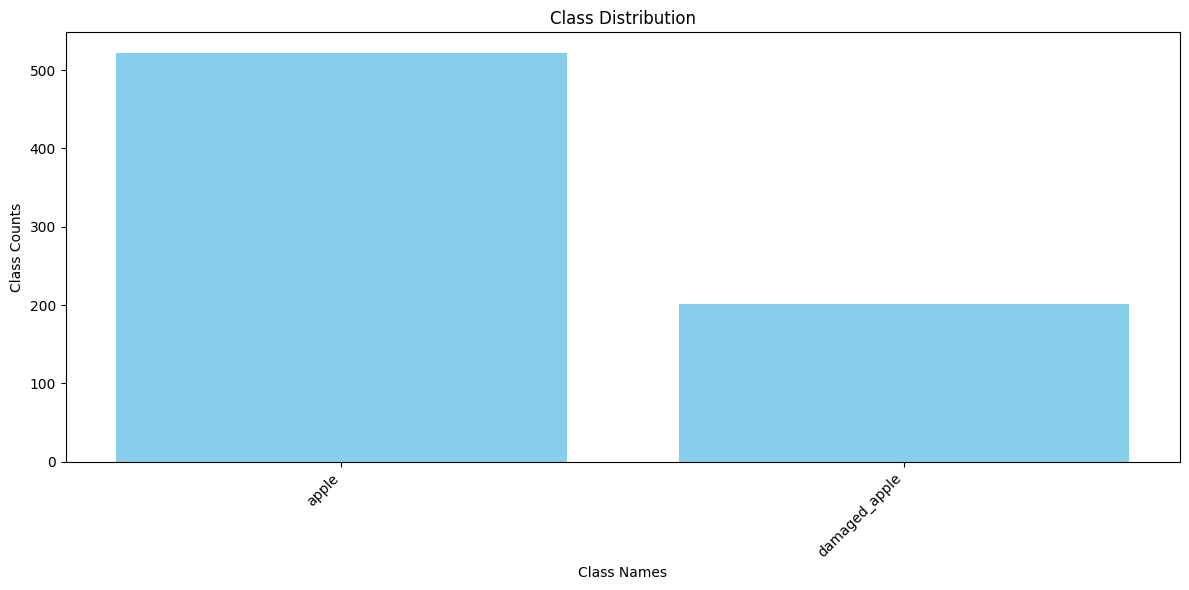

In [ ]:
class_names = classes_test.index.get_level_values('names')

# Nilai frekuensi kelas
class_counts = classes_test.values

# Buat plot
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel('Class Names')
plt.ylabel('Class Counts')
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')

# Tampilkan plot
plt.tight_layout()
plt.show()

In [ ]:
# bounding box coordinates point harus berada di kolom terpisah
df_test['xmin'] = -1
df_test['ymin'] = -1
df_test['xmax'] = -1
df_test['ymax'] = -1

df_test[['xmin', 'ymin', 'xmax', 'ymax']] = np.stack(df_test['boxes'][i] for i in range(len(df_test['boxes'])))

df_test.drop(columns = ['boxes'], inplace = True)
df_test['xmin'] = df_test['xmin'].astype(np.float)
df_test['ymin'] = df_test['ymin'].astype(np.float)
df_test['xmax'] = df_test['xmax'].astype(np.float)
df_test['ymax'] = df_test['ymax'].astype(np.float)

In [ ]:
df_test.drop(columns = ['names'], inplace = True)
df_test.head()

,xml_path,img_path,img_id,labels,xmin,ymin,xmax,ymax
0,/content/Apple/valid/labels/damaged_apple--295...,/content/Apple/train/damaged_apple--295-_jpg.r...,damaged_apple--295-_jpg.rf.8172d0e132487a2e3f5...,2,77.0,98.0,348.0,326.0
1,/content/Apple/valid/labels/apple--332-_jpg.rf...,/content/Apple/train/apple--332-_jpg.rf.cb5723...,apple--332-_jpg.rf.cb572319a5a842b99028fa2e5c4...,1,6.0,226.0,101.0,336.0
2,/content/Apple/valid/labels/apple--332-_jpg.rf...,/content/Apple/train/apple--332-_jpg.rf.cb5723...,apple--332-_jpg.rf.cb572319a5a842b99028fa2e5c4...,1,10.0,110.0,112.0,211.0
3,/content/Apple/valid/labels/apple--332-_jpg.rf...,/content/Apple/train/apple--332-_jpg.rf.cb5723...,apple--332-_jpg.rf.cb572319a5a842b99028fa2e5c4...,1,43.0,72.0,151.0,117.0
4,/content/Apple/valid/labels/apple--332-_jpg.rf...,/content/Apple/train/apple--332-_jpg.rf.cb5723...,apple--332-_jpg.rf.cb572319a5a842b99028fa2e5c4...,2,144.0,70.0,261.0,177.0


In [ ]:
df_test.shape

(723, 8)

## Data Train and Test

In [ ]:
df_train

,xml_path,img_path,img_id,labels,xmin,ymin,xmax,ymax
0,/content/Apple/train/labels/damaged_apple--281...,/content/Apple/train/damaged_apple--281-_jpg.r...,damaged_apple--281-_jpg.rf.3187dcc1b9fc9837b54...,2,78.0,76.0,367.0,349.0
1,/content/Apple/train/labels/apple--238-_jpg.rf...,/content/Apple/train/apple--238-_jpg.rf.12d678...,apple--238-_jpg.rf.12d6781e8149121336be40628e0...,1,58.0,143.0,176.0,251.0
2,/content/Apple/train/labels/apple--238-_jpg.rf...,/content/Apple/train/apple--238-_jpg.rf.12d678...,apple--238-_jpg.rf.12d6781e8149121336be40628e0...,1,155.0,194.0,278.0,312.0
3,/content/Apple/train/labels/apple--238-_jpg.rf...,/content/Apple/train/apple--238-_jpg.rf.12d678...,apple--238-_jpg.rf.12d6781e8149121336be40628e0...,1,231.0,135.0,349.0,258.0
4,/content/Apple/train/labels/apple--238-_jpg.rf...,/content/Apple/train/apple--238-_jpg.rf.12d678...,apple--238-_jpg.rf.12d6781e8149121336be40628e0...,1,141.0,101.0,262.0,185.0
...,...,...,...,...,...,...,...,...
1975,/content/Apple/train/labels/apple--212-_jpg.rf...,/content/Apple/train/apple--212-_jpg.rf.d31d59...,apple--212-_jpg.rf.d31d5900a8a5ac7822a6f12e442...,1,116.0,161.0,199.0,239.0
1976,/content/Apple/train/labels/apple--212-_jpg.rf...,/content/Apple/train/apple--212-_jpg.rf.d31d59...,apple--212-_jpg.rf.d31d5900a8a5ac7822a6f12e442...,1,209.0,187.0,313.0,282.0
1977,/content/Apple/train/labels/apple--212-_jpg.rf...,/content/Apple/train/apple--212-_jpg.rf.d31d59...,apple--212-_jpg.rf.d31d5900a8a5ac7822a6f12e442...,1,195.0,148.0,285.0,216.0
1978,/content/Apple/train/labels/apple--212-_jpg.rf...,/content/Apple/train/apple--212-_jpg.rf.d31d59...,apple--212-_jpg.rf.d31d5900a8a5ac7822a6f12e442...,1,113.0,119.0,194.0,176.0


In [ ]:
df_test

,xml_path,img_path,img_id,labels,xmin,ymin,xmax,ymax
0,/content/Apple/valid/labels/damaged_apple--295...,/content/Apple/train/damaged_apple--295-_jpg.r...,damaged_apple--295-_jpg.rf.8172d0e132487a2e3f5...,2,77.0,98.0,348.0,326.0
1,/content/Apple/valid/labels/apple--332-_jpg.rf...,/content/Apple/train/apple--332-_jpg.rf.cb5723...,apple--332-_jpg.rf.cb572319a5a842b99028fa2e5c4...,1,6.0,226.0,101.0,336.0
2,/content/Apple/valid/labels/apple--332-_jpg.rf...,/content/Apple/train/apple--332-_jpg.rf.cb5723...,apple--332-_jpg.rf.cb572319a5a842b99028fa2e5c4...,1,10.0,110.0,112.0,211.0
3,/content/Apple/valid/labels/apple--332-_jpg.rf...,/content/Apple/train/apple--332-_jpg.rf.cb5723...,apple--332-_jpg.rf.cb572319a5a842b99028fa2e5c4...,1,43.0,72.0,151.0,117.0
4,/content/Apple/valid/labels/apple--332-_jpg.rf...,/content/Apple/train/apple--332-_jpg.rf.cb5723...,apple--332-_jpg.rf.cb572319a5a842b99028fa2e5c4...,2,144.0,70.0,261.0,177.0
...,...,...,...,...,...,...,...,...
718,/content/Apple/valid/labels/apple--241-_jpg.rf...,/content/Apple/train/apple--241-_jpg.rf.64ba08...,apple--241-_jpg.rf.64ba08a4374493b00fb52f2d16d...,1,341.0,144.0,383.0,183.0
719,/content/Apple/valid/labels/apple--241-_jpg.rf...,/content/Apple/train/apple--241-_jpg.rf.64ba08...,apple--241-_jpg.rf.64ba08a4374493b00fb52f2d16d...,1,364.0,176.0,406.0,224.0
720,/content/Apple/valid/labels/apple--241-_jpg.rf...,/content/Apple/train/apple--241-_jpg.rf.64ba08...,apple--241-_jpg.rf.64ba08a4374493b00fb52f2d16d...,1,340.0,259.0,391.0,301.0
721,/content/Apple/valid/labels/apple--241-_jpg.rf...,/content/Apple/train/apple--241-_jpg.rf.64ba08...,apple--241-_jpg.rf.64ba08a4374493b00fb52f2d16d...,1,333.0,300.0,384.0,337.0


# Object Dataset

In [ ]:
class AppleDataset(Dataset):
  def __init__(self, dataframe, image_dir, transform = None):
    super().__init__()

    self.image_ids = dataframe['img_id'].unique()
    self.df = dataframe
    self.image_dir = image_dir
    self.transforms = transforms

  def __getitem__(self, index: int):
    image_id = self.image_ids[index]
    records = self.df[self.df['img_id'] == image_id]
    image_path = os.path.join(self.image_dir, f'{image_id}.jpg')
    image = Image.open(image_path).convert('RGB')
    image = self.transforms(image)

    boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
    boxes = torch.tensor(boxes, dtype = torch.float32)

    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    area = torch.as_tensor(area, dtype = torch.float32)

    label = records['labels'].values
    labels = torch.as_tensor(label, dtype = torch.int64)

    iscrowd = torch.zeros((records.shape[0],), dtype = torch.int64)

    target = {}
    target['boxes'] = boxes
    target['labels'] = labels
    target['image_id'] = torch.tensor([index])
    target['area'] = area
    target['iscrowd'] = iscrowd

    return image, target

  def __len__(self) -> int:
    return self.image_ids.shape[0]

# Data Transform

In [ ]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data Loader

In [ ]:
train_dataset = AppleDataset(df_train, img_train_path, transforms)
test_dataset = AppleDataset(df_test, img_test_path, transforms)

train_data_loader = DataLoader(train_dataset, batch_size = 4, shuffle = True, num_workers = 3, collate_fn = utils.collate_fn)
test_data_loader = DataLoader(test_dataset, batch_size = 4 , shuffle = False, num_workers = 3, collate_fn = utils.collate_fn)

In [ ]:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
image, target = train_dataset[1]
print(image.shape, '\n', target)

torch.Size([3, 416, 416]) 
 {'boxes': tensor([[ 58., 143., 176., 251.],
        [155., 194., 278., 312.],
        [231., 135., 349., 258.],
        [141., 101., 262., 185.]]), 'labels': tensor([1, 1, 1, 1]), 'image_id': tensor([1]), 'area': tensor([12744., 14514., 14514., 10164.]), 'iscrowd': tensor([0, 0, 0, 0])}


# Sample View

In [ ]:
class UnNormalize(object):
  def __init__(self, mean, std):
    self.mean = mean
    self.std = std

  def __call__(self, tensor):
    for t, m, s in zip(tensor, self.mean, self.std):
      t.mul_(s).add_(m)
    return tensor

In [ ]:
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [ ]:
def display(image, targets, dataset):
  fig, ax = plt.subplots(1)
  unnormalized_image = unorm(image).cpu().permute(1, 2, 0).numpy()
  ax.imshow(unnormalized_image)
  boxes = targets['boxes']
  labels = targets['labels']
  label_color = ['green', 'blue']
  for j, box in enumerate(boxes):
    xmin, ymin, xmax, ymax = box
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth = 2, edgecolor = label_color[labels[j] - 1], facecolor = 'none')
    ax.add_patch(rect)

  plt.show()

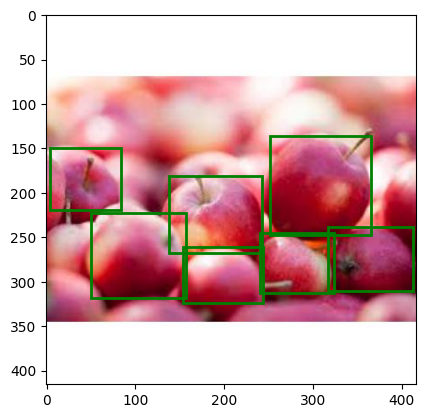

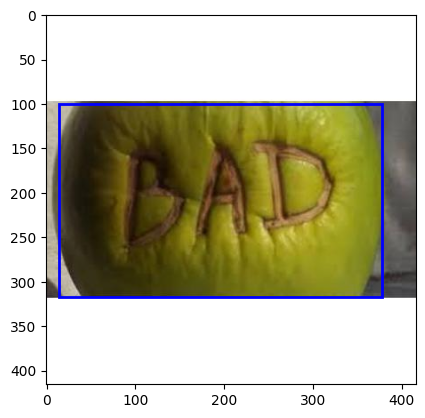

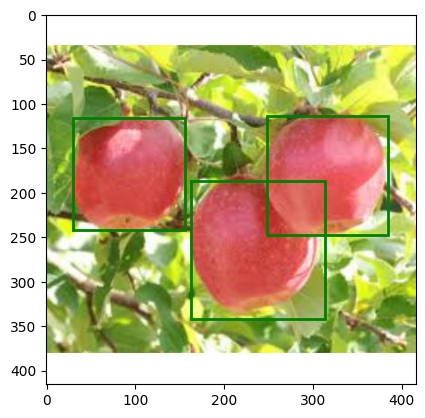

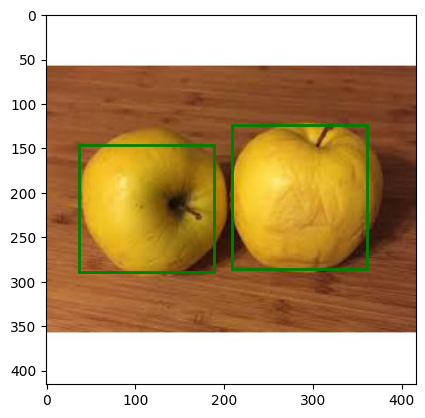

In [ ]:
for i, batch in enumerate(train_data_loader):
  if i == 3:
    for j in range(len(batch[0])):
      image = batch[0][j]
      target = batch[1][j]
      display(image, target, train_dataset)
      if j == 4:
        break

# Model

In [ ]:
def model_resnet50(num_classes):
  # load a model pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model

In [ ]:
num_classes = 3

model = model_resnet50(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9, weight_decay = 0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 243MB/s]


In [ ]:
num_epoch = 50
result_mAP = []
best_epoch = None

for epoch in range(num_epoch):
  train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq = 30)
  lr_scheduler.step()
  results = evaluate(model, test_data_loader, device = device)
  result_mAP.append(results.coco_eval['bbox'].stats[1])
  if result_mAP[-1] == max(result_mAP):
    best_save_path = os.path.join(f'Best-Model{epoch}.pth')
    torch.save(model.state_dict(), best_save_path)
    best_epoch = int(epoch)
    print(f'\n\nmodel from epoch number {epoch} saved!\n result is {max(result_mAP)}\n\n')

# Saving the last model
save_path = os.path.join(f'Last-epoch-Model{num_epoch-1}.pth')
torch.save(model.state_dict(), save_path)
print(f'model from last epoch(no.{num_epoch-1}) saved')

Epoch: [0]  [  0/122]  eta: 0:17:55  lr: 0.000046  loss: 1.7927 (1.7927)  loss_classifier: 1.1885 (1.1885)  loss_box_reg: 0.2150 (0.2150)  loss_objectness: 0.3477 (0.3477)  loss_rpn_box_reg: 0.0416 (0.0416)  time: 8.8154  data: 0.3311  max mem: 3014
Epoch: [0]  [ 30/122]  eta: 0:01:31  lr: 0.001285  loss: 0.7359 (1.0863)  loss_classifier: 0.2585 (0.4227)  loss_box_reg: 0.3790 (0.3546)  loss_objectness: 0.0382 (0.2861)  loss_rpn_box_reg: 0.0084 (0.0228)  time: 0.7273  data: 0.0158  max mem: 3174
Epoch: [0]  [ 60/122]  eta: 0:00:53  lr: 0.002523  loss: 0.3872 (0.8123)  loss_classifier: 0.1496 (0.3088)  loss_box_reg: 0.2089 (0.3316)  loss_objectness: 0.0071 (0.1555)  loss_rpn_box_reg: 0.0064 (0.0163)  time: 0.7415  data: 0.0159  max mem: 3174
Epoch: [0]  [ 90/122]  eta: 0:00:26  lr: 0.003762  loss: 0.3389 (0.6839)  loss_classifier: 0.1377 (0.2642)  loss_box_reg: 0.1741 (0.2934)  loss_objectness: 0.0069 (0.1114)  loss_rpn_box_reg: 0.0057 (0.0149)  time: 0.7626  data: 0.0170  max mem: 3174


# Inference

In [ ]:
model.load_state_dict(torch.load('/content/Last-epoch-Model49.pth'))
model.to(device)

evaluate(model, test_data_loader, device)

creating index...
index created!
Test:  [ 0/45]  eta: 0:00:33  model_time: 0.4241 (0.4241)  evaluator_time: 0.0043 (0.0043)  time: 0.7395  data: 0.2998  max mem: 3176
Test:  [44/45]  eta: 0:00:00  model_time: 0.3693 (0.3620)  evaluator_time: 0.0074 (0.0087)  time: 0.3905  data: 0.0164  max mem: 3176
Test: Total time: 0:00:17 (0.3983 s / it)
Averaged stats: model_time: 0.3693 (0.3620)  evaluator_time: 0.0074 (0.0087)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.496
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.774
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.556
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.137
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.365
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.623
 Average Recall     (AR) @[ IoU=